In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv #download dataset

--2023-12-05 00:35:36--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-12-05 00:35:36 (40.5 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



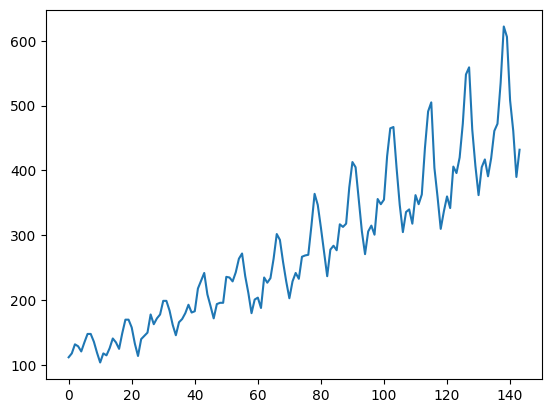

Epoch: 0, loss: 0.04025
Epoch: 100, loss: 0.00644
Epoch: 200, loss: 0.00286
Epoch: 300, loss: 0.00245
Epoch: 400, loss: 0.00202
Epoch: 500, loss: 0.00183
Epoch: 600, loss: 0.00177
Epoch: 700, loss: 0.00174
Epoch: 800, loss: 0.00172
Epoch: 900, loss: 0.00171
Epoch: 1000, loss: 0.00169
Epoch: 1100, loss: 0.00167
Epoch: 1200, loss: 0.00164
Epoch: 1300, loss: 0.00161
Epoch: 1400, loss: 0.00160
Epoch: 1500, loss: 0.00159
Epoch: 1600, loss: 0.00158
Epoch: 1700, loss: 0.00157
Epoch: 1800, loss: 0.00157
Epoch: 1900, loss: 0.00157


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.profiler import profile, record_function, ProfilerActivity

training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::zeros         0.07%     276.000us         0.08%     302.000us     151.000us       2.17 Kb           0 b             2  
                  aten::empty         0.01%      37.000us         0.01%      37.000us       6.167us      10.86 Kb      10.86 Kb             6  
                  aten::zero_         0.00%       1.000us         0.00%       1.000us       0.500us           0 b           0 b             2  
                 aten::detach         0.00%      16.000us         0.00%      17.000us       8.500us           0 b           0 b         

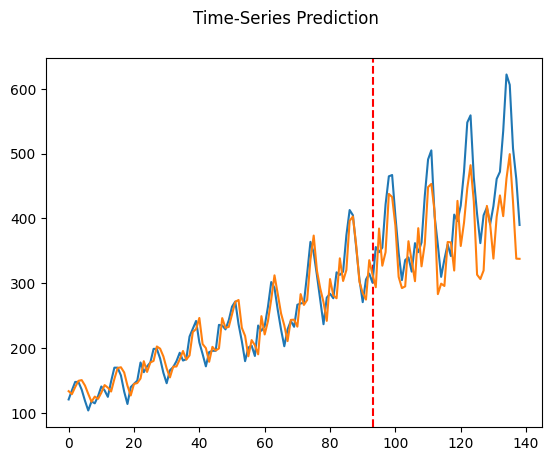

In [3]:
MODE='prof'
if(MODE=='prof'):
  with profile(
      activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                   #activities=[ProfilerActivity.CPU],
                    with_stack=True,
                    profile_memory=True,
                    record_shapes=True
                ) as prof:
                    with torch.no_grad():
                      lstm.eval()
                      train_predict = lstm(dataX)
if MODE == 'prof':
                print(prof \
                        .key_averages(group_by_input_shape=False, group_by_stack_n=4) \
                        #.key_averages(group_by_input_shape=False) \
                        .table(sort_by="self_cuda_time_total", row_limit=-1, top_level_events_only=False))
                        #.table(sort_by="cpu_time_total", row_limit=-1, top_level_events_only=False))

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [4]:
print(lstm)

LSTM(
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


In [17]:
params = []
model = lstm.fc
for param in model.parameters():
    params.append(param.view(-1))

In [18]:
print(len(params))

2


In [19]:
print(params)

[tensor([-1.0453, -0.0811], grad_fn=<ViewBackward0>), tensor([0.6285], grad_fn=<ViewBackward0>)]


In [23]:
model2=lstm.lstm
params = []
for param in model2.parameters():
    params.append(param.view(-1))

In [24]:
print(params)

[tensor([-0.7264,  0.5035, -1.4184,  0.5784, -1.7155,  0.5800, -1.1095, -2.3311],
       grad_fn=<ViewBackward0>), tensor([ 1.1420,  2.6388,  0.0874,  0.7428, -0.0397, -1.6058, -1.8690,  0.0593,
        -0.8078, -1.4447, -0.5063, -0.1268, -0.3153,  0.8521,  2.7619,  1.7921],
       grad_fn=<ViewBackward0>), tensor([ 0.7096,  0.4143,  0.1035, -0.6128,  0.6456,  0.6220,  0.4066,  0.4519],
       grad_fn=<ViewBackward0>), tensor([ 0.6855,  0.3130, -0.8512,  0.6550,  1.1633,  0.2450,  1.2293, -0.0743],
       grad_fn=<ViewBackward0>)]


In [25]:
print(model2)

LSTM(1, 2, batch_first=True)
